In [1]:
!pip install ISLP -q
!pip install great_tables
!pip install stargazer

In [9]:
import numpy as np
import pandas as pd
from great_tables import GT as GT
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from stargazer.stargazer import Stargazer

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import ModelSpec as MS
from functools import partial
import networkx as nx

from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART



df = pd.read_stata('./replication_sample.dta')
df_main = df[df['main_sample']==1]
df_main_adj = df_main.drop(columns=['negative_HHIchange','timetoswitch', 'diffr_hat'])

#change if you want negative_HHIchange and timetoswitch included
df_main = df_main_adj
df_main = df_main.astype('float32')

df_main = df_main.dropna()

df_main.columns
print(df_main.shape)

(52476, 29)


# Ridge Regression

In [11]:
design = MS(df_main.columns.drop(['allP_sample','main_sample','ind_sample','constant', 'logr_hat', 'logr_bar', 
                                 'r_hat', 'HHI_bar', 'shiftmerge', 'sapientmerge', 'merklemerge', 'forsmanmerge'])).fit(df_main)
Y = np.array(df_main['logr_hat'])
R = design.fit_transform(df_main)
D = R.drop('intercept', axis=1)
X = np.asarray(D)

Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]

print(D)
print(X)


          year  newhclust   HHI_hat  num_words   num_char  long_tail  \
61      2015.0   100302.0  0.250000   1.666667  12.666667   0.000000   
62      2016.0   100302.0  0.250000   1.714286  10.142858   0.142857   
63      2017.0   100302.0  0.500016   1.500000   9.000000   0.000000   
66      2016.0   100303.0  1.000000   1.800000  13.000000   0.000000   
69      2015.0   100304.0  1.000000   2.200000  14.000000   0.000000   
...        ...        ...       ...        ...        ...        ...   
221399  2016.0  2299907.0  0.186252   5.000000  31.000000   1.000000   
221402  2016.0  2299908.0  0.169746   4.000000  22.000000   1.000000   
221403  2017.0  2299908.0  0.075408   4.000000  22.000000   1.000000   
221406  2016.0  2299909.0  0.180000   3.000000  18.000000   0.000000   
221411  2017.0  2299910.0  0.200000   6.000000  36.000000   1.000000   

         branded  numind  numberofresults    logcpc     logvol    lognum  sim  \
61      0.000000     1.0         0.001094  0.602493   

In [13]:
#D.describe()
df_main['logr_hat'].describe()

count    52476.000000
mean        10.412332
std          1.960181
min          0.126677
25%          9.493245
50%         10.365668
75%         11.541053
max         19.574286
Name: logr_hat, dtype: float64

In [5]:
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0,
                                 alphas=lambdas)[1]
soln_array.shape

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2945448.5, tolerance: 589.0896606445312
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Object

(17, 100)

In [6]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,year,newhclust,HHI_hat,num_words,num_char,long_tail,branded,numind,numberofresults,logcpc,logvol,lognum,sim,cluster,evermerged,own_branded,other_branded
negative log(lambda),,,,,,,,,,,,,,,,,
-17.747652,-8.351374e-12,2.700537e-09,-9.807402e-09,-9.227985e-09,-9.142369e-09,-7.635303e-09,3.507131e-09,2.708497e-09,4.209683e-09,7.349167e-09,2.045391e-08,9.742502e-09,-1.389642e-09,2.700627e-09,-1.268027e-08,3.507131e-09,2.031380e-09
-17.515068,-1.053824e-11,3.407691e-09,-1.237554e-08,-1.164440e-08,-1.153636e-08,-9.634660e-09,4.425497e-09,3.417735e-09,5.312017e-09,9.273596e-09,2.580990e-08,1.229364e-08,-1.753529e-09,3.407804e-09,-1.600068e-08,4.425497e-09,2.563311e-09
-17.282483,-1.329775e-11,4.300019e-09,-1.561616e-08,-1.469356e-08,-1.455724e-08,-1.215756e-08,5.584344e-09,4.312692e-09,6.703006e-09,1.170195e-08,3.256840e-08,1.551282e-08,-2.212702e-09,4.300161e-09,-2.019057e-08,5.584344e-09,3.234532e-09
-17.049899,-1.677986e-11,5.426009e-09,-1.970536e-08,-1.854117e-08,-1.836915e-08,-1.534110e-08,7.046642e-09,5.442000e-09,8.458233e-09,1.476619e-08,4.109667e-08,1.957496e-08,-2.792114e-09,5.426188e-09,-2.547761e-08,7.046642e-09,4.081516e-09
-16.817315,-2.117379e-11,6.846845e-09,-2.486534e-08,-2.339630e-08,-2.317923e-08,-1.935827e-08,8.891853e-09,6.867025e-09,1.067308e-08,1.863282e-08,5.185811e-08,2.470079e-08,-3.523247e-09,6.847072e-09,-3.214910e-08,8.891853e-09,5.150289e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.347861,6.683949e-02,1.205388e-02,-6.681573e-01,5.022138e-02,-8.282079e-02,-1.311629e-02,7.356425e-02,3.818319e-02,2.758102e-02,1.067259e+00,1.623831e+00,1.268929e+00,2.277189e-02,1.232425e-02,-8.759101e-02,7.356425e-02,2.118269e-02
4.580446,6.730347e-02,1.002060e-02,-6.711649e-01,5.350029e-02,-8.333472e-02,-1.380479e-02,7.367580e-02,4.191028e-02,2.675890e-02,1.074600e+00,1.634076e+00,1.277444e+00,2.277312e-02,1.039805e-02,-8.434273e-02,7.367626e-02,2.094363e-02
4.813030,6.767657e-02,7.721223e-03,-6.735542e-01,5.621456e-02,-8.379073e-02,-1.440166e-02,7.376851e-02,4.665412e-02,2.609567e-02,1.080510e+00,1.642295e+00,1.284281e+00,2.277183e-02,7.773213e-03,-8.172135e-02,7.376878e-02,2.075140e-02


<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/var/folders/j1/krsnnj4x2p54phvkb1tg2csr0000gn/T/ipykernel_58141/2922449943.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


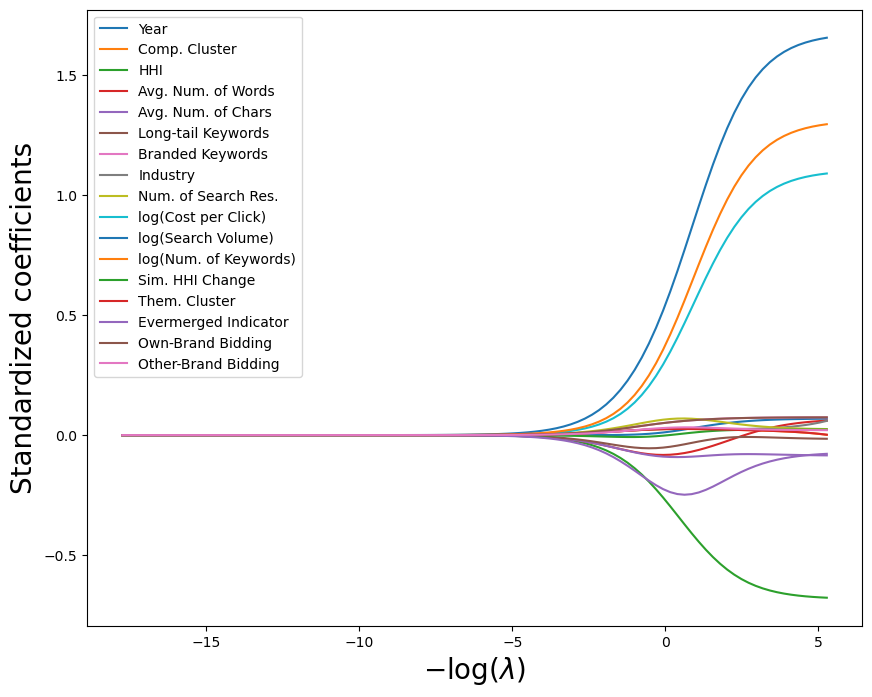

In [7]:
path_fig, ax = subplots(figsize=(10,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
mylabels = {'year': 'Year',
            'newhclust': 'Comp. Cluster',
            'HHI_hat': 'HHI',
            'num_words': 'Avg. Num. of Words',
            'num_char': 'Avg. Num. of Chars',
            'long_tail': 'Long-tail Keywords',
            'branded': 'Branded Keywords',
            'numind': 'Industry',
            'numberofresults': 'Num. of Search Res.',
            'logcpc': 'log(Cost per Click)',
            'logvol': 'log(Search Volume)',
            'lognum': 'log(Num. of Keywords)',
            'sim': 'Sim. HHI Change',
            'cluster': 'Them. Cluster',
            'evermerged': 'Evermerged Indicator',
            'own_branded': 'Own-Brand Bidding',
            'other_branded': 'Other-Brand Bidding'}
handles, labels = ax.get_legend_handles_labels()

# Replace default labels with custom labels from mylabels
new_labels = [mylabels.get(label, label) for label in labels]  # Map the labels

# Create the custom legend
ax.legend(handles, new_labels, loc='upper left', frameon=True)

In [8]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.949e+04, tolerance: 2.016e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=55.99012084009919, l1_ratio=0))])

# #Ridge Regression Cross-Validation

In [10]:
#K = 5
#kfold = skm.KFold(K,
#                  random_state=0,
#                  shuffle=True)

#param_grid = {'ridge__alpha': lambdas}
#grid = skm.GridSearchCV(pipe,
#                        param_grid,
#                        cv=kfold,
#                        scoring='neg_mean_squared_error')
#grid.fit(X, Y)
#grid.best_params_['ridge__alpha']
#grid.best_estimator_

In [11]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80929.703125, tolerance: 16.18593978881836
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Obj

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([5.10161128e+07, 4.04293970e+07, 3.20396057e+07, 2.53908396e+07,
       2.01218061e+07, 1.59461872e+07, 1.26370807e+07, 1.00146703e+07,
       7.93645497e+06, 6.28950483e+06, 4.98432502e+06, 3.94999234e+06,
       3.13030138e+06, 2.48071031e+06, 1.96592049e+06, 1.55795837e+06,
       1.23465537e+06, 9.78443263e+05,...
       4.23544731e-01, 3.35651956e-01, 2.65998435e-01, 2.10799211e-01,
       1.67054770e-01, 1.32388048e-01, 1.04915264e-01, 8.31435524e-02,
       6.58898434e-02, 5.22165741e-02, 4.13807420e-02, 3.27935303e-02,
       2.59883120e-02, 2.05952928e-02, 1.63214173e-02, 1.29344441e-02,
       1.02503258e-02, 8.12320786e-03, 6.43750331e-03, 5.10161128e-03]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
/var/folders/j1/krsnnj4x2p54phvkb1tg2csr0000gn/T/ipykernel_58141/2588336222.py:16: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


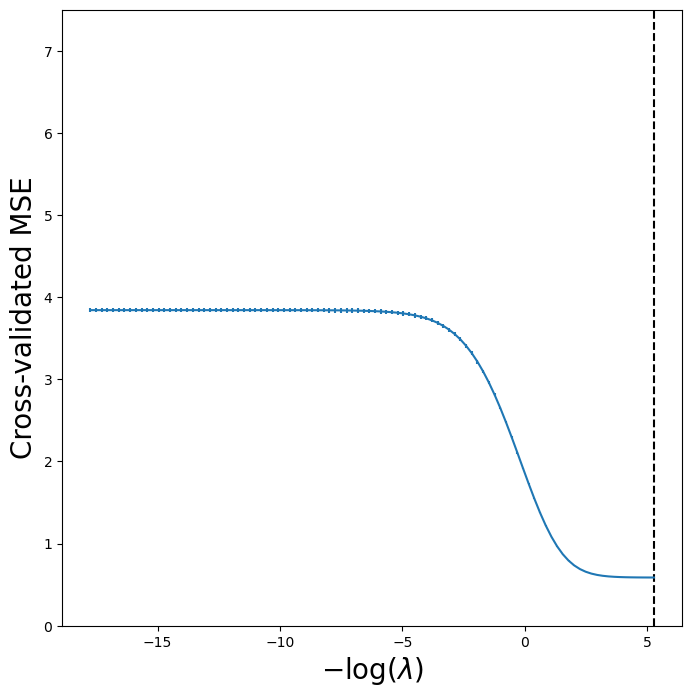

In [12]:
#ridge_fig, ax = subplots(figsize=(8,8))
#ax.errorbar(-np.log(lambdas),
#            -grid.cv_results_['mean_test_score'],
#            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
#ax.set_ylim([0,7.5])
#ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
#ax.set_ylabel('Cross-validated MSE', fontsize=20);

tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([0,7.5])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

# LASSO

In [14]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.0010434786557188048

In [15]:
lambdas, soln_array = skl.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))


In [16]:
#design_2 = MS(df_main.columns.drop(['allP_sample','main_sample','ind_sample','constant', 'evermerged','logr_hat',
                                    #'logr_bar', 'r_hat'])).fit(df_main)
#D2 = design_2.fit_transform(df_main)
#D2 = D2.drop('intercept', axis=1)
#X2 = np.asarray(D2)

#Xs2 = X2 - X2.mean(0)[None,:]
#X_scale2 = X2.std(0)
#Xs2 = Xs2 / X_scale2[None,:]

#lambdas, soln_array = skl.Lasso.path(Xs2,
                                    #Y,
                                    #l1_ratio=1,
                                    #n_alphas=100)[:2]
#soln_path = pd.DataFrame(soln_array.T,
                         #columns=D2.columns,
                         #index=-np.log(lambdas))

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/var/folders/j1/krsnnj4x2p54phvkb1tg2csr0000gn/T/ipykernel_58141/1141222792.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


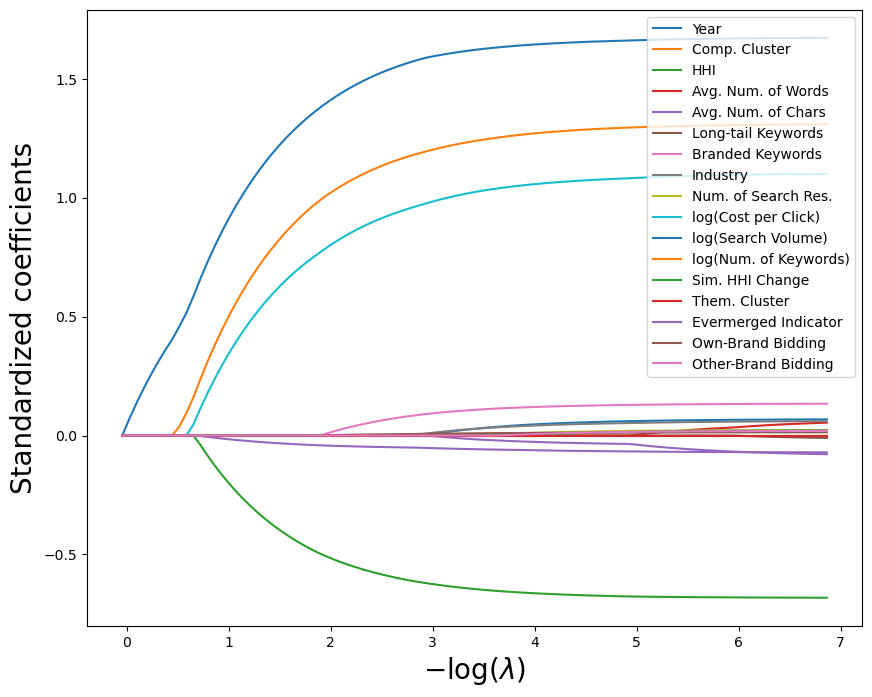

In [17]:
path_fig, ax = subplots(figsize=(10,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='best')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20);

mylabels = {'year': 'Year',
            'newhclust': 'Comp. Cluster',
            'HHI_hat': 'HHI',
            'num_words': 'Avg. Num. of Words',
            'num_char': 'Avg. Num. of Chars',
            'long_tail': 'Long-tail Keywords',
            'branded': 'Branded Keywords',
            'numind': 'Industry',
            'numberofresults': 'Num. of Search Res.',
            'logcpc': 'log(Cost per Click)',
            'logvol': 'log(Search Volume)',
            'lognum': 'log(Num. of Keywords)',
            'sim': 'Sim. HHI Change',
            'cluster': 'Them. Cluster',
            'evermerged': 'Evermerged Indicator',
            'own_branded': 'Own-Brand Bidding',
            'other_branded': 'Other-Brand Bidding'}
handles, labels = ax.get_legend_handles_labels()

# Replace default labels with custom labels from mylabels
new_labels = [mylabels.get(label, label) for label in labels]  # Map the labels

# Create the custom legend
ax.legend(handles, new_labels, loc='upper right', frameon=True)



<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/folders/j1/krsnnj4x2p54phvkb1tg2csr0000gn/T/ipykernel_58141/370557611.py:7: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


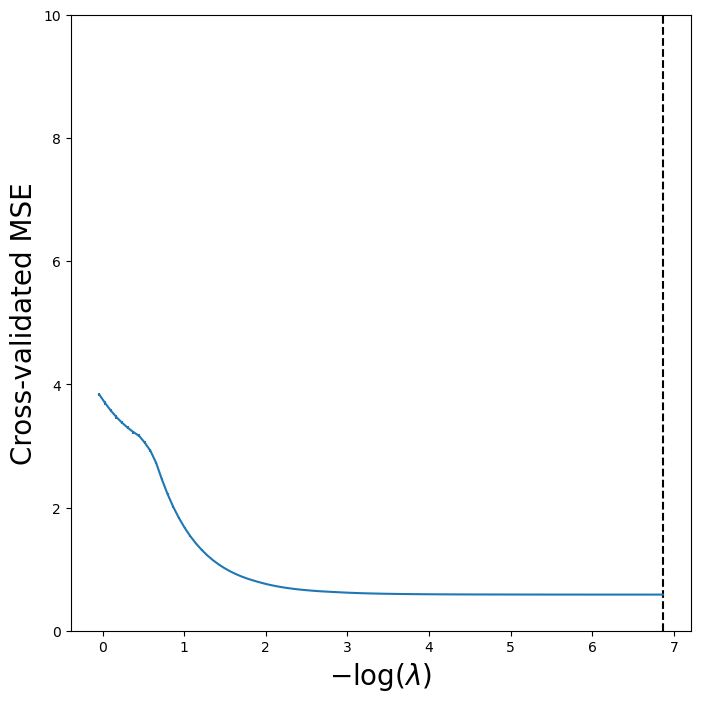

In [18]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([0,10])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [19]:
tuned_lasso.coef_

array([ 0.06836046,  0.        , -0.68199533,  0.05406335, -0.0785408 ,
       -0.01033987,  0.13363764,  0.06028326,  0.02285422,  1.1006265 ,
        1.6724536 ,  1.3087318 ,  0.0215814 ,  0.        , -0.0707375 ,
        0.01363519,  0.01929436], dtype=float32)

# Regression Tree

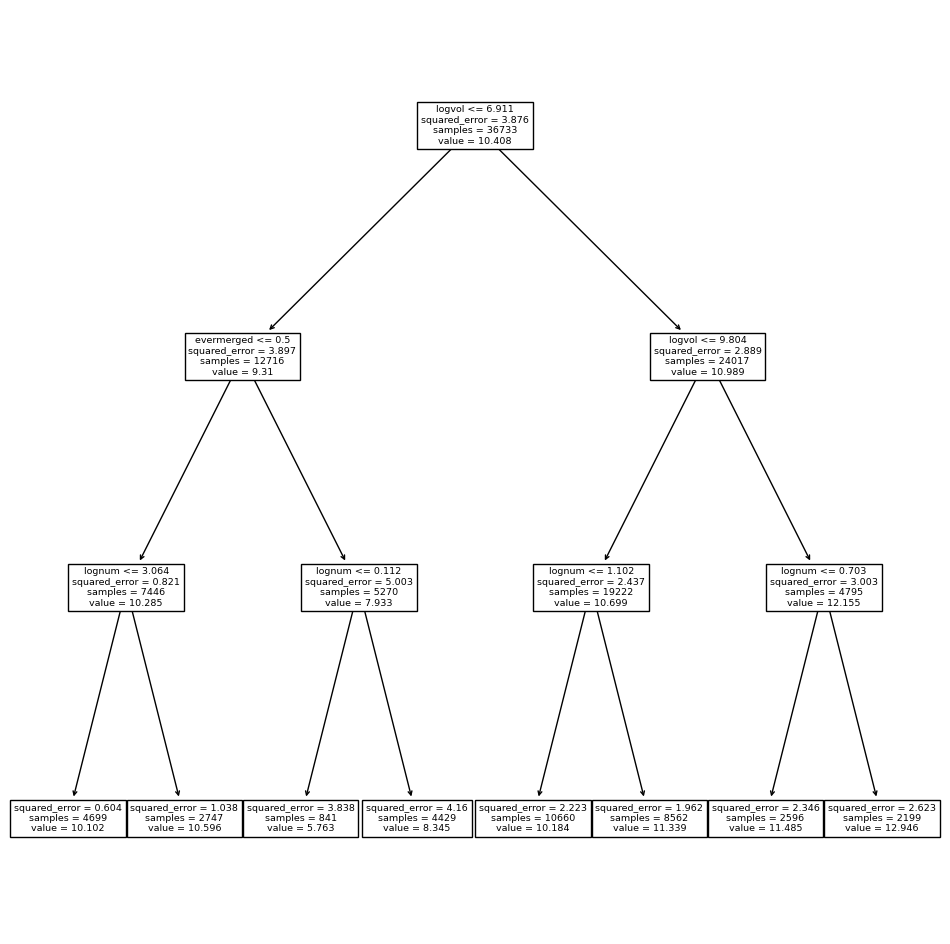

In [21]:
feature_names = list(D.columns)
X = np.asarray(D)

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                df_main['logr_hat'],
                                test_size=0.3,
                                random_state=0)

reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax,
          fontsize=None);



In [22]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

best_ = grid.best_estimator_
tree_MSE = np.mean((y_test - best_.predict(X_test))**2)
tree_MSE

2.156706517235679

# Bagging

In [24]:
bag_main = RF(max_features=X_train.shape[1], random_state=0)
bag_main.fit(X_train, y_train)

RandomForestRegressor(max_features=17, random_state=0)

0.44532143410125763

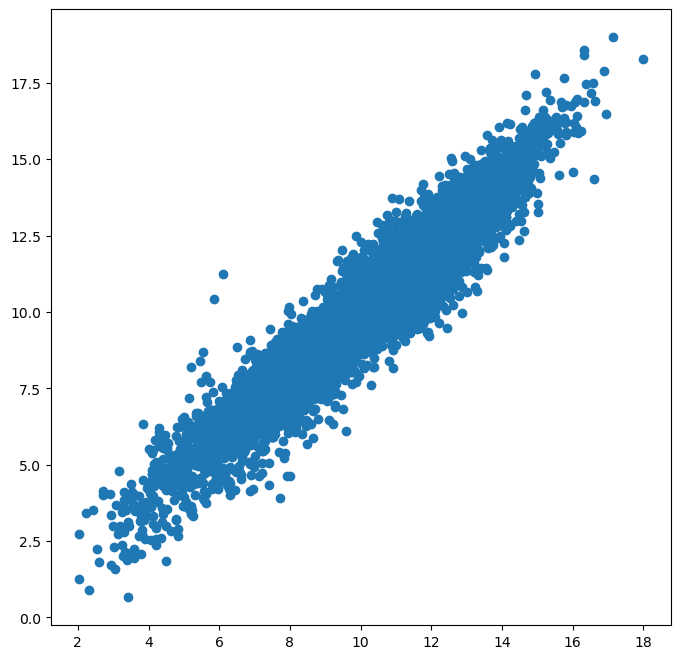

In [25]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_main.predict(X_test)
ax.scatter(y_hat_bag, y_test)
bag100_MSE = np.mean((y_test - y_hat_bag)**2)
bag100_MSE

In [26]:
bag_main = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_main.predict(X_test)
bag500_MSE = np.mean((y_test - y_hat_bag)**2)
bag500_MSE

0.43939792451858184

In [27]:
#random forest, now using 6 variables for each tree
RF_main = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_main.predict(X_test)
RF_MSE = np.mean((y_test - y_hat_RF)**2)
RF_MSE

0.45333409438444605

In [178]:
#do this for weekly report 4 and project
feature_imp = pd.DataFrame(
    {'Variable Importance':RF_main.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='Variable Importance', ascending=False)
#plot bar graph

,Variable Importance
logvol,0.319443
lognum,0.175153
logcpc,0.122240
evermerged,0.104798
HHI_hat,0.091511
numberofresults,0.036132
newhclust,0.026122
cluster,0.025458
num_words,0.021716
num_char,0.019443


In [180]:
feature_imp = feature_imp.sort_values(by='Variable Importance', ascending=False)
feature_imp['Variable Importance'] = feature_imp['Variable Importance'].round(2)

print(feature_imp.to_latex())

\begin{tabular}{lr}
\toprule
 & Variable Importance \\
\midrule
logvol & 0.320000 \\
lognum & 0.180000 \\
logcpc & 0.120000 \\
evermerged & 0.100000 \\
HHI_hat & 0.090000 \\
numberofresults & 0.040000 \\
newhclust & 0.030000 \\
cluster & 0.030000 \\
num_words & 0.020000 \\
num_char & 0.020000 \\
long_tail & 0.010000 \\
numind & 0.010000 \\
branded & 0.010000 \\
own_branded & 0.010000 \\
year & 0.010000 \\
sim & 0.000000 \\
other_branded & 0.000000 \\
\bottomrule
\end{tabular}



# Boosting

In [31]:
#should tune learning rate using crossvalidation for different values of lambda
boost_df = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_df.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

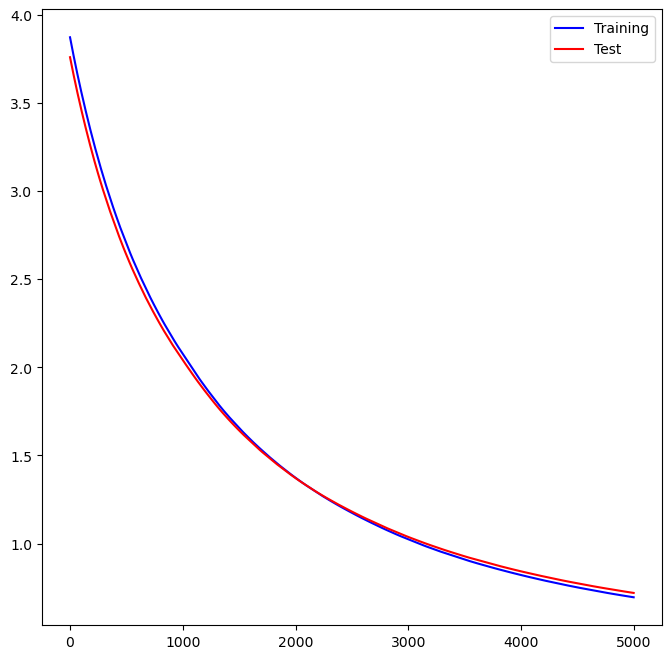

In [32]:
test_error = np.zeros_like(boost_df.train_score_)
for idx, y_ in enumerate(boost_df.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_df.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_df.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

In [33]:
y_hat_boost = boost_df.predict(X_test);
boostLR0001_MSE = np.mean((y_test - y_hat_boost)**2)

In [34]:
boost_df = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_df.fit(X_train,
                 y_train)
y_hat_boost = boost_df.predict(X_test);
boostLR02_MSE = np.mean((y_test - y_hat_boost)**2)

In [35]:
boost_df = GBR(n_estimators=5000,
                   learning_rate=0.5,
                   max_depth=3,
                   random_state=0)
boost_df.fit(X_train,
                 y_train)
y_hat_boost = boost_df.predict(X_test);
boostLR05_MSE = np.mean((y_test - y_hat_boost)**2)

In [36]:
error_table = {
    'Model': ['Tree', 'Bagging', 'Random Forest', 'Boosting'],
    'MSE': [round(tree_MSE, 3), round(bag100_MSE, 3), round(RF_MSE, 3), round(boostLR02_MSE, 3)]
}

error_df = pd.DataFrame(error_table)

(
    GT(error_df)
        .tab_header(title="MSE Comparison Between Models")
        .fmt_currency(columns=["open", "high", "low", "close"])
        .fmt_date(columns="date", date_style="wd_m_day_year")
        .fmt_number(columns="Mode", compact=True)
)

GT(_tbl_data=           Model    MSE
0           Tree  2.157
1        Bagging  0.445
2  Random Forest  0.453
3       Boosting  0.381, _body=<great_tables._gt_data.Body object at 0x16984bc20>, _boxhead=Boxhead([ColInfo(var='Model', type=<ColInfoTypeEnum.default: 1>, column_label='Model', column_align='left', column_width=None), ColInfo(var='MSE', type=<ColInfoTypeEnum.default: 1>, column_label='MSE', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x169c47620>, _spanners=Spanners([]), _heading=Heading(title='MSE Comparison Between Models', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x1676affb0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x169a74a70>, <great_tables._gt_data.FormatInfo object at 0x1677790a0>, <great_tables._gt_data.FormatInfo object at 0x1676fd880>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=OptionsInfo(scss=True, category='heading', type='value', value='center'), heading_title_font_size=OptionsInfo(scss=True, category='heading', type='px', value='125%'), heading_title_font_weight=OptionsInfo(scss=True, category='head

# BART

In [94]:
bart = BART(random_state=0, burnin=5, ndraw=15, num_trees=200)
bart.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [96]:
yhat_test = bart.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

0.4999169051847162

In [172]:
var_inclusion = pd.Series(bart.variable_inclusion_.mean(0),
                               index=D.columns)

var_inclusion = var_inclusion.to_frame(name='Variable Importance')
var_inclusion = var_inclusion.sort_values(by='Variable Importance', ascending=False)
var_inclusion['Variable Importance'] = var_inclusion['Variable Importance'].round(2)

var_inclusion

,Variable Importance
logvol,35.93
lognum,31.47
logcpc,25.93
HHI_hat,22.33
evermerged,21.53
sim,21.53
numberofresults,19.33
long_tail,18.13
num_char,17.20
num_words,17.07


In [184]:
variable_importance_compare = pd.merge(left=feature_imp, left_index=True, right=var_inclusion, right_index=True, how='left')            
variable_importance_compare
print(variable_importance_compare.to_latex())

\begin{tabular}{lrr}
\toprule
 & Variable Importance_x & Variable Importance_y \\
\midrule
logvol & 0.320000 & 35.930000 \\
lognum & 0.180000 & 31.470000 \\
logcpc & 0.120000 & 25.930000 \\
evermerged & 0.100000 & 21.530000 \\
HHI_hat & 0.090000 & 22.330000 \\
numberofresults & 0.040000 & 19.330000 \\
newhclust & 0.030000 & 14.330000 \\
cluster & 0.030000 & 15.470000 \\
num_words & 0.020000 & 17.070000 \\
num_char & 0.020000 & 17.200000 \\
long_tail & 0.010000 & 18.130000 \\
numind & 0.010000 & 15.070000 \\
branded & 0.010000 & 12.530000 \\
own_branded & 0.010000 & 11.930000 \\
year & 0.010000 & 10.330000 \\
sim & 0.000000 & 21.530000 \\
other_branded & 0.000000 & 12.930000 \\
\bottomrule
\end{tabular}

